# Team member:
- Wutong Gao (wg894)
- Jinfeng Hong (jh6011)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression

# 1. "Momentum Crashes" Review

The logic of the paper:
- In the introduction section, the paper points out what is the momentum crashes and when it probably occur.
- In the following sections, he provided experiments to show the crash and how to deal with this problem.

The paper "Momentum Crashes" provides the following insights.
- Momentum crashes usually occur following market declines and when market volatility is high, and are contemporaneous with marekt "rebounds".
- Patterns during two crashes are suggestive of the possibility that the changing beta of the momentum portfolio may partly be driving the momentum crashes.
- To be more specific, in bear market states, and in particular when market volatility is high, the down-market betas of the past-losers are low, but the up-market betas are very large, resulting in an asymmetry in the winner and loser exposure to market returns during extreme times. 
- To deal with this problem, the paper then shows that a simple dynamically-weighted version of the momentum portfolio can approximately doubles the Sharpe ratio of the static momentum strategy—and does so consistently across eight different markets and asset classes, as well as multiple time periods.

Section contents:
- section 2 reprent the results of the analysis of the momentum in US common stock from the 1927 through 2013. Including constructing 10 portfolio base on their ranks comparing their performance with risk-free market and analysis WML (winner-minus-loser) portfolio in details.
- section 3 uses the insights from the section 2 to assess the performance of the strategy which can dynamically adjust the weights of the underlying WML strategy using the foracasted return and the variance.
- section 4 investigate whether the anomalous performance of the momentum strategy can be explained by dynamic loadings on other known factors such as those of volatility risk. To be more specific, since in the previous section, the researcher points out that the low returns of the momentum portfolio in “crash” states cannot be explained by market risk, so he whether the conditional risk (size and value factors) can do it.
- section 5 study the momentum crash in other international equities and other assets

# 2. Compare DJTMNMO and MOM

The overlapping time of DJTMNMO and DJTMNMOT is start on 2012-09-21 and end on 2020-05-11,
<br>we are going to use this time periods data and get the MOM data from finance.yahoo.com.
<br>we also save them into two different csv files, one called DJTMNMO.csv, another is MOM.csv

In [6]:
# import data
df = pd.read_csv('DJTMNMO.csv')
df['Date'] = [datetime.datetime.strptime(df['Date'].iloc[i], '%m/%d/%y') for i in range(len(df))]
df['isweekday'] = [True if df['Date'].iloc[i].weekday()<5 else False for i in range(len(df))]
df1 = df[df['isweekday']==True].iloc[:,:3].set_index('Date')
df = pd.read_csv('MOM.csv')
df['Date'] = [datetime.datetime.strptime(df['Date'].iloc[i], '%m/%d/%y') for i in range(len(df))]
df2 = df.set_index('Date')
data = pd.concat([df1, df2], join = 'inner', axis = 1)
data

,DJTMNMO,DJTMNMOT,MOM
Date,,,
2012-09-21,1056.43,1052.70,24.809999
2012-09-24,1058.32,1054.60,25.010000
2012-09-25,1074.14,1070.40,25.240000
2012-09-26,1072.97,1069.32,25.299999
2012-09-27,1071.15,1067.39,25.299999
...,...,...,...
2020-05-05,1443.13,1363.20,29.389999
2020-05-06,1452.91,1372.54,29.180000
2020-05-07,1454.12,1373.43,29.320000


#### The scaling value 42.4305 is calculated from data.DJTMNMOT[0]/data.MOM[0] = 42.43047329425528, we take 43.4305. The reason we use DJTMNMOT for scaling process not DJTMNMO is because DJTMNMOT and MOM are total return index, so we can use them for comparison purpose while DJTMNMO is a pure price.

In [12]:
data.DJTMNMOT[0]/data.MOM[0]

42.43047329425528

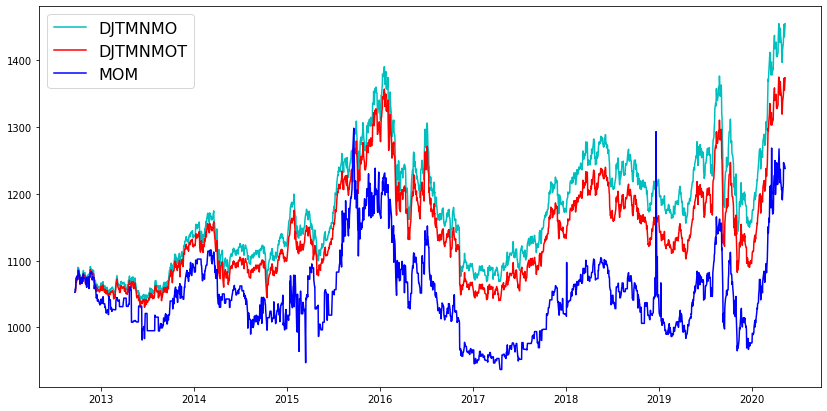

In [3]:
# scale MOM for ease of comparison
plt.figure(figsize=(14,7))
plt.plot(data.index.values, data['DJTMNMO'], 'c')
plt.plot(data.index.values, data['DJTMNMOT'], 'r')
plt.plot(data.index.values, data['MOM'] * 42.4305, 'b')
plt.legend(["DJTMNMO", "DJTMNMOT", "MOM"], loc = "upper left", fontsize = 16) 

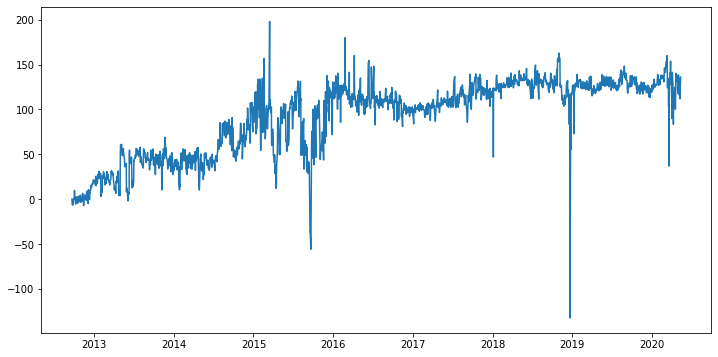

In [4]:
# plot the differences between two time series
plt.figure(figsize=(12,6))
plt.plot(data.index.values, data['DJTMNMOT'] - data['MOM'] * 42.4305)

- For ease of comparison, scale MOM so that MOM and DJTMNMO have same initial value. 
- Since MOM tracks Dow Jones U.S. Thematic Market Neutral Momentum Total Return Index, MOM and DJTMNMO (DJTMNMOT) move together for most of the time. 
- On average, DJTMNMO (DJTMNMOT) performed better than MOM for the overlapping interval.

# 3. Replicate DJTMNMO
- Replicate DJTMNMO by regression on MTUM and SPY
- Dynamically estimate regression coefficients using the lagged 42 days (2 months) of returns

In [5]:
df = pd.read_csv('MTUM.csv')
df['Date'] = [datetime.datetime.strptime(df['Date'].iloc[i], '%m/%d/%y') for i in range(len(df))]
df3 = df.set_index('Date')
df = pd.read_csv('SPY.csv')
df['Date'] = [datetime.datetime.strptime(df['Date'].iloc[i], '%m/%d/%y') for i in range(len(df))]
df4 = df.set_index('Date')
data = pd.concat([df1, df2, df3, df4], join = 'inner', axis = 1)
r_MTUM = [data['MTUM'].iloc[i]/data['MTUM'].iloc[i-1]-1 for i in range(1,len(data))]
r_MTUM.insert(0, 0)
data['r_MTUM'] = r_MTUM
r_SPY = [data['SPY'].iloc[i]/data['SPY'].iloc[i-1]-1 for i in range(1,len(data))]
r_SPY.insert(0, 0)
data['r_SPY'] = r_SPY
r_DJTMNMO = [data['DJTMNMO'].iloc[i]/data['DJTMNMO'].iloc[i-1]-1 for i in range(1,len(data))]
r_DJTMNMO.insert(0, 0)
data['r_DJTMNMO'] = r_DJTMNMO
data.head()

,DJTMNMO,DJTMNMOT,MOM,MTUM,SPY,r_MTUM,r_SPY,r_DJTMNMO
Date,,,,,,,,
2013-04-22,1072.72,1065.90,24.379999,46.293701,134.732071,0.000000,0.000000,0.000000
2013-04-23,1076.85,1070.00,25.000000,47.475590,136.120987,0.025530,0.010309,0.003850
2013-04-24,1071.56,1064.72,25.000000,46.875565,136.207321,-0.012639,0.000634,-0.004912
2013-04-25,1072.40,1065.62,25.000000,47.102852,136.759445,0.004849,0.004054,0.000784
2013-04-26,1072.44,1065.76,24.879999,47.066479,136.517853,-0.000772,-0.001767,0.000037


In [6]:
# Dynamically estimate regression coefficients
beta0 = []
beta1 = []
beta2 = []
for i in range(43, len(data)):
    X = data[['r_SPY', 'r_MTUM']].iloc[i-42:i].values.reshape(-1,2)
    y = data['r_DJTMNMO'].iloc[i-42:i].values
    reg = LinearRegression().fit(X, y)
    beta0.append(reg.intercept_)
    beta1.append(reg.coef_[0])
    beta2.append(reg.coef_[1])
beta0 = [0]*43 + beta0
beta1 = [0]*43 + beta1
beta2 = [0]*43 + beta2
data['beta0'] = beta0
data['beta1'] = beta1
data['beta2'] = beta2

In [7]:
# Replicate DJTMNMO using only MTUM and SPY
data['r_exante'] = data['beta0'] + data['beta1']*data['r_SPY'] + data['beta2'] * data['r_MTUM']
DJTMNMO_exante = []
DJTMNMO_exante.append(data['DJTMNMO'].iloc[43])
for i in range(44, len(df)):
    new_price = (data['r_exante'].iloc[i]+1) * DJTMNMO_exante[-1]
    DJTMNMO_exante.append(new_price)
DJTMNMO_exante = np.array(data['DJTMNMO'].iloc[:43]).tolist() + DJTMNMO_exante
data['DJTMNMO_exante'] = DJTMNMO_exante

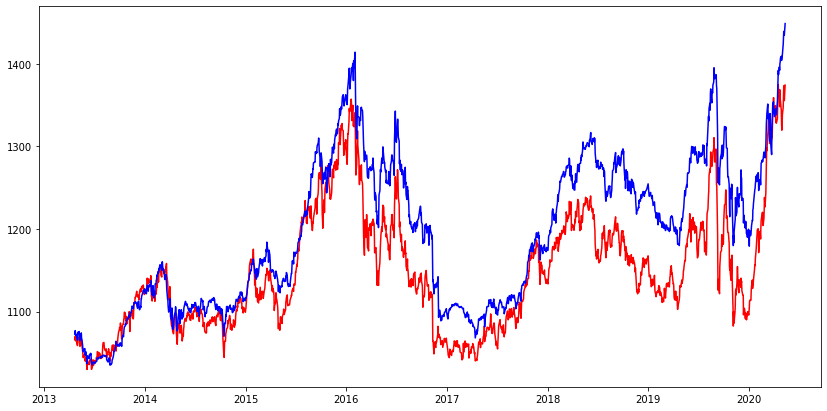

In [8]:
plt.figure(figsize=(14,7))
plt.plot(data.index.values, data['DJTMNMOT'], 'r')
plt.plot(data.index.values, data['DJTMNMO_exante'], 'b')

In [9]:
# Replicate DJTMNMO using one step ahead forecast
data['r_exante'] = data['beta0'] + data['beta1']*data['r_SPY'] + data['beta2'] * data['r_MTUM']
DJTMNMO_exante = []
DJTMNMO_exante.append(data['DJTMNMO'].iloc[43])
for i in range(44, len(df)):
    new_price = (data['r_exante'].iloc[i]+1) * data['DJTMNMO'].iloc[i-1]
    DJTMNMO_exante.append(new_price)
DJTMNMO_exante = np.array(data['DJTMNMO'].iloc[:43]).tolist() + DJTMNMO_exante
data['DJTMNMO_exante'] = DJTMNMO_exante

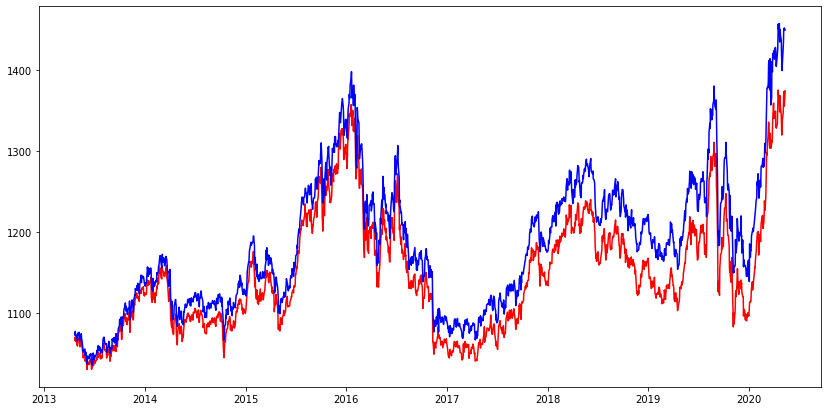

In [10]:
plt.figure(figsize=(14,7))
plt.plot(data.index.values, data['DJTMNMOT'], 'r')
plt.plot(data.index.values, data['DJTMNMO_exante'], 'b')

# 4. Quantitative Strategy
Insights from the paper
- The paper propose an optimal dynamic momentum strategy, which at each point in time, is scaled up or down so as to maximize the unconditional Sharpe ratio of the dynamic portfolio. 
- Specifically, given a conditional expected excess return and conditional volatility for the momentum strategy, first show theoretically that, to maximize the unconditional Sharpe ratio, a dynamic strategy should scale the weight on the long-short strategy so that, at each point in time, the conditional volatility of the scaled strategy is proportional to the conditional Sharpe ratio of the strategy. 
- Then, use the insights from analysis on the forecastability of both the momentum premium and momentum volatility to generate the dynamic weights.
- The optimal dynamic strategy significantly outperforms the standard static momentum strategy, more than doubling its Sharpe ratio.
    
Another Possible Strategy
- From the paper we can learn that risk management is very important in improving the performance of momentum factor. Inspired by the paper, since the time-varying systematic risk of the momentum strategy is highly correlated with realized market volatility, we could scale the market neutral momentum portfolio by realized market volatility.
- The new return r' of the scaled portfolio would be r' = r * target volatility / realized market volatility, where r is the return for the unscaled market neutral momentum portfolio.
- By scaling the portfolio, we could reduce our exposure to momentum risk when market volatility is high.
- Also some factor mentioned in the paper can be also used in our strategy, such a makertcap and variance swap on the S&P500, CRSP VW index return in excess of the risk-free rate, a small minus big (SMB) stock factor, a high BE/ME minus low BE/ME (HML) factor，and premium as well. Since the model setting is updated, the result of this strategy may be different from the paper. Therefore we need to do multiple models with combinations consisting of some of those factors.
- Notice that premium or transaction cost is alway an important factor that we should consider if we want to apply the model into real market, we may need to alway consider and include this factor in our model.

# 5. Momentum Factor Trade Volume
- According to www.etf.com, there are 41 Momentum ETFs currently traded in the U.S. markets and the total assets under management of these Momentum ETFs is 19.70B USD.
- The largest three Momentum ETFs are MTUM (12.65B USD), PDP (1.93B USD), XMMO (800.97M USD).
- We can assume that most of the people track momentum factor using ETFs. Therefore, the total AUM that track momentum factor would be 19.70B USD.
- Additionally, the daily trading volume of people who track momentum factor would be the total daily trading volume of these 41 ETFs, which is roughly 219M USD.